# Description
The goals of this notebook are to
- find out character encoding, usage, and distribution in the corpora
- remove non-essential data
- normalize, standardize, and simplify the language (see also the REM handbook, https://www.linguistics.rub.de/rem/documentation/simple.html)

# Imports and settings

In [1]:
import pandas as pd
import numpy as np
import string
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean

In [2]:
from ddp_util import *
from formutils import *

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
plt.style.use(["bmh", "plot.mplstyle"])
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [5]:
final_language_filtered = pd.read_json(
    "../data-push/0b-preprocessing-main/charters-filtered-final.json", encoding="utf-8"
)
ref = pd.read_json("../data-push/0a-transform-reference/df-ref.json", encoding="utf-8")

In [6]:
df = explode_columns(final_language_filtered[["atom_id", "cei_abstract_joined", "cei_tenor_joined", "year"]])
df_ref = ref

# Generate filter candidates

Check how many unique characters are contained in the corpora

In [7]:
unique_chars_df = get_unique_characters("".join(df.cei_tenor_joined.to_list()))
unique_chars_df_ref = get_unique_characters("".join(df_ref.text.to_list()))

In [8]:
print(len(unique_chars_df))
print(len(unique_chars_df_ref))

165
111


Check how many non-standard characters are contained in the corpora


In [9]:
ascii_letters = list(string.ascii_letters)
allowed = [",", ".", " "]  # Others are not removed, e.g., ";", ":". These are sometimes used to represent graphemics

In [10]:
reduced_unique_characters = sorted(list(set(unique_chars_df) - set(ascii_letters) - set(allowed)))
reduced_unique_characters_ref = sorted(list(set(unique_chars_df_ref) - set(ascii_letters) - set(allowed)))

In [11]:
print(len(reduced_unique_characters))
print(len(reduced_unique_characters_ref))

110
56


Find out general distribution of non-standard characters.
This shows that only 15 % of these charters have a simple character set, i.e., only ascii_letter, comma, dot, whitespace


In [12]:
filtered = filter_df_by_strings(
    dataframe=df, column="cei_tenor_joined", filter_strings=reduced_unique_characters, mode="substrate"
)
len(filtered) / len(df)

0.14764443477314765

Find out specific distribution of non-standard characters

In [13]:
rows = []

for i in reduced_unique_characters:
    filtered = filter_df_by_strings(dataframe=df, column="cei_tenor_joined", filter_strings=i, mode="filter")
    contained_in = len(filtered)
    row = {"char": i, "contained_in": contained_in}
    rows.append(row)

result_df = pd.DataFrame(rows).sort_values("contained_in", ascending=False)

with pd.option_context("display.max_colwidth", None, "display.max_rows", 25):
    display(result_df)

result_df.to_json("../data-push/0c-preprocessing-norm/character-usages-unicode.json")

with open("../data-push/0c-preprocessing-norm/character-usages-utf8.json", "w", encoding="utf-8") as f:
    json.dump(result_df.to_dict(orient="records"), f, ensure_ascii=False)

,char,contained_in
83,ü,2583
89,ů,2318
37,|,2159
9,),2043
8,(,2014
...,...,...
46,º,1
34,_,1
26,<,1
6,&,1


Results show which characters deserve special attention.

Inspect candidates to reason processing

In [14]:
rows = []
# individuals = ["%"]

for i in reduced_unique_characters:  # _ref
    filtered = filter_df_by_strings(
        dataframe=df, column="cei_tenor_joined", filter_strings=i, mode="filter"
    )  # change iterator for i for individuals
    sample = filtered.sample(n=1)
    [cei_tenor_joined] = sample.cei_tenor_joined
    [atom_id] = sample.atom_id
    url = chatomid_to_url(atom_id)
    concordance = get_concordance(cei_tenor_joined, i)
    row = {"char": i, "conc": concordance, "atom_id": atom_id, "url": url}
    rows.append(row)

result_df = pd.DataFrame(rows)

with pd.option_context("display.max_colwidth", None, "display.max_rows", 25):
    display(result_df)

result_df.to_json("../data-push/0c-preprocessing-norm/symbolic-concordances.json")

,char,conc,atom_id,url
0,\t,uerzicht haben getan Vnd daruber so geben wir - - [ \t ] disen prief ze eine offene Vrchunde - - Vnd sint,"tag:www.monasterium.net,2011:/charter/AT-StiAK/KlosterneuburgCanReg/1313_V_12",https://www.monasterium.net/mom/AT-StiAK/KlosterneuburgCanReg/1313_V_12/charter
1,\n,"en vnd hat Im auch versprochen für den obgenanten [ \n ] Wilhalm seynen bruder, das der denselben handel d","tag:www.monasterium.net,2011:/charter/AT-StiAStP/UK/1242",https://www.monasterium.net/mom/AT-StiAStP/UK/1242/charter
2,!,"gelegen ist dacz Iniching, besucht vnd vnpeschut ( [ ! ] ), mit allen den rechten die dar czu gehoerent vn","tag:www.monasterium.net,2011:/charter/FreisBm/1339_VIII_14",https://www.monasterium.net/mom/FreisBm/1339_VIII_14/charter
3,"""","[ "" ] Wir Margaret(1) von Gots genaden pfallentzgrefinn","tag:www.monasterium.net,2011:/charter/AT-StiASchl/Urkunden/1341_I_06",https://www.monasterium.net/mom/AT-StiASchl/Urkunden/1341_I_06/charter
4,#,"nder in, daz der schade alz groz vnd alz geuerlich [ # ] [ # ] [ # ] [ # ] were, daz man in solte bessern, alz er daz ve","tag:www.monasterium.net,2011:/charter/CSGV/1319_XI_10",https://www.monasterium.net/mom/CSGV/1319_XI_10/charter
...,...,...,...,...
105,„,emselben Tag verkauft derselbe (Proler) demselben [ „ ] vnsrew aygne Halbe Hub di gelegen ist ze Mezze,"tag:www.monasterium.net,2011:/charter/OOEUB/1378_III_06.1",https://www.monasterium.net/mom/OOEUB/1378_III_06.1/charter
106,†,ar und darnach in dem ain und sechtzigistem jare. [ † ] hoc est verum [ † ] .,"tag:www.monasterium.net,2011:/charter/AT-StiAG/GoettweigOSB/1361_V_31",https://www.monasterium.net/mom/AT-StiAG/GoettweigOSB/1361_V_31/charter
107,•,n Hertzog ze Oesterr.. . Embieten vnsern getrewen [ • ] [ • ] dem Richter dem Rat vnd den Purgern gemainlich,"tag:www.monasterium.net,2011:/charter/OOEUB/1378_VI_22",https://www.monasterium.net/mom/OOEUB/1378_VI_22/charter
108,…,"genanten purgelschaft schaden nement, ir wer mit [ … ] [ … ] [ … ] [ … ] ..r, mit rechten, mit nachreyten oder mit ph","tag:www.monasterium.net,2011:/charter/AT-StiAG/GoettweigOSB/1352_I_05",https://www.monasterium.net/mom/AT-StiAG/GoettweigOSB/1352_I_05/charter


In [15]:
rows = []

for i in reduced_unique_characters_ref:
    filtered = filter_df_by_strings(dataframe=df_ref, column="text", filter_strings=i, mode="filter")
    sample = filtered.sample(n=1)
    [text] = sample.text
    [id] = sample.id
    concordance = get_concordance(text, i)

    row = {"char": i, "conc": concordance, "id": id}
    rows.append(row)

result_df = pd.DataFrame(rows)

with pd.option_context("display.max_colwidth", None, "display.max_rows", 25):
    display(result_df)

result_df.to_json("../data-push/0c-preprocessing-norm/symbolic-concordances-ref.json")

,char,conc,id
0,!,sô er schier bîhtet sô er êrst die sünde getuot. [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [ [ ! ] [ ! ] ] [,M322
1,"""","wande selbe alsus gebôt aperi os tuum et implebo. [ "" ] daz sprichet tuo ûf dînen munt ich ervüll dir ze",M103
2,#,ete si durch nôt. Isaac unde Ismahel. di tâten ein [ # ] ander vile wê. dô bat diu vrouwe Sarê. den hêrren,M087
3,%,in ariese. wande ir scheidet ouch mit unminnen. ap [ % ] [ % ] il\ dicoet. sô dû vindes daz signum in tauruse.,M146
4,',tunge mîn. den verse alliu menige drî antwürte zuo [ ' ] guonlîche dem vater. danne selbe der bruoder nov,M358
...,...,...,...
51,û,domine labia mea aperies. n [ û ] gestate hêrre mir des. daz ich dîn lop gespreche,M223
52,ü,pfen Adâm habete sich behalten dô sich Luzifer dô [ ü ] bele gevienc und Adâm diu gotes wort [ ü ] bergienc dô,M013B
53,ý,an der siechen krancheit. unde gelouben daz ein em [ ý ] na wînes iegelîchen ze tage genüege. den aber got,M508
54,ſ,ich diene im harte gerne. sô ich iemer allerbezzi [ ſ ] te kan. sîn swert zuhte der drâte. unde lief den,M522


List and apply semi-automatic filters

Sequences that are removed before anything else

In [16]:
regexes = [
    r"\(.*?\)",  # irregular insertions
    r"\[.*?\]",  # additions, comments, references
    r"\d+",  # references, normalized dates
]

In [17]:
df_processed = delete_strings_by_regex(df, "cei_tenor_joined", regex_list=regexes)
df_ref_processed = delete_strings_by_regex(df_ref, "text", regex_list=regexes)

List sequences that are transformerd

In [18]:
transform_chars = {
    "ſ": "s",
    "&": "und",
    "c͛": "cetera",
    "ŵ": "w",
    "Æ": "Ae",
    "æ": "ae",
    "Œ": "Oe",
    "œ": "oe"
}

In [19]:
df_processed_transformed = df_processed.assign(
    cei_tenor_joined=df_processed["cei_tenor_joined"].apply(lambda x: map_strings(x, transform_chars))
).copy()

df_ref_processed_transformed = df_ref_processed.assign(
    text=df_ref_processed["text"].apply(lambda x: map_strings(x, transform_chars))
).copy()

In [20]:
test_chars = get_unique_characters("".join(df_processed_transformed.cei_tenor_joined.to_list()))
test_chars_ref = get_unique_characters("".join(df_ref_processed_transformed.text.to_list()))
print(list(char for char in test_chars if char in transform_chars))
print(list(char for char in test_chars_ref if char in transform_chars))

[]
[]


### List characters that result in removing the text
Some require a deletion of the text from the corpus. Reasons for this are

In [21]:
strings_to_remove_by = [
    "“",  # transcription, insertion, or comment
    "„",  # transcription, insertion, or comment
    '"',  # transcription, insertion, or comment; single comma escape
    "dorsal",  # comment
    "Aussteller",  # insertion
    "Siegler",  # insertion
    " sic ",  # insertion
    "½",  # insertion
    "*",  # reference
    "etc.",  # missing text
    "-",  # missing text
    "—",  # missing text
    "…",  # missing text
    "#",  # missing text; unclear
    "~",  # missing text; unclear
    "=",  # missing text; unclear
    "_",  # unclear
    "«",  # unclear
    "$",  # unclear
    "{",  # unclear
    "}",  # unclear
    "•",  # unclear
    "º",  # unclear
    "<",  # unclear
    ">",  # unclear
    "»",  # unclear
    "«",  # unclear
    "",  # unclear
]

In [22]:
df_processed_transformed_filtered = filter_df_by_strings(
    dataframe=df_processed_transformed,
    column="cei_tenor_joined",
    filter_strings=strings_to_remove_by,
    mode="substrate",
).copy()

df_ref_processed_transformed_filtered = filter_df_by_strings(
    dataframe=df_ref_processed_transformed, column="text", filter_strings=strings_to_remove_by, mode="substrate"
).copy()

In [23]:
test_chars = get_unique_characters("".join(df_processed_transformed_filtered.cei_tenor_joined.to_list()))
test_chars_ref = get_unique_characters("".join(df_ref_processed_transformed_filtered.text.to_list()))
print(list(char for char in test_chars if char in strings_to_remove_by))
print(list(char for char in test_chars_ref if char in strings_to_remove_by))

[]
[]


### List characters that are removed
Here, symbols that signal diacritics are removed. This is because both corpora, but especially the charters, have highly irregular spelling. They are therefore standardized and simplified, as exercized in the REM.

In [24]:
strings_to_remove = [
    "|",  # especially as doubles used to mark paragraphs
    "+",  # used to mark symbol relevant for diplomatics
    "†",  # used to mark symbol relevant for diplomatics
    "?",  # used to express uncertainty in transcription, often with brackets
    "!",  # emphasis
    "¬",  # some graphemic gradient or break
    "♂",  # unclear
    "§",  # unclear
    "%",  # unclear
    "≈",  # unclear
    "~",  # unclear
    "-",  # missing text
    "—",  # missing text
    "\t",  # tab
    "\n",  # newline
    "°",  # diacritics
    "^",  # diacritics
    "´",  # diacritics
    "`",  # diacritics
    "\\",  # diacritics
    "/",  # diacritics
    "ˇ",  # diacritics
    "`",  # diacrtiics
    "'",  # diacritics
    "¨",  # diacritics
    "(",  # clutter
    ")",  # clutter
    "[",  # clutter
    "]",  # clutter
]

In [25]:
df_processed_semiauto = delete_substrings(df_processed_transformed_filtered, "cei_tenor_joined", strings_to_remove)
df_ref_processed_semiauto = delete_substrings(df_ref_processed_transformed_filtered, "text", strings_to_remove)

In [26]:
test_chars = get_unique_characters("".join(df_processed_semiauto.cei_tenor_joined.to_list()))
test_chars_ref = get_unique_characters("".join(df_ref_processed_semiauto.text.to_list()))
print(list(char for char in test_chars if char in strings_to_remove))
print(list(char for char in test_chars_ref if char in strings_to_remove))

[]
[]


# List and apply automatic filters

In [27]:
def clean_mhg_string(text):
    cleaned = clean(
        text=text,
        fix_unicode=True,  # fixes potential unicode errors
        to_ascii=True,  # transliterates to closest ASCII representation
        lower=False,
        no_line_breaks=False,  # fully strips line breaks as opposed to only normalizing them
        no_punct=False,  # keeps punctuation
        lang="en",  # is "en" since less intrusive and in line with  conventions of REM team, e.g. ö != oe
    )
    return cleaned

In [28]:
df_processed_full = df_processed_semiauto.assign(
    cei_tenor_joined=df_processed_semiauto["cei_tenor_joined"].apply(lambda x: clean_mhg_string(x))
).copy()

df_ref_processed_full = df_ref_processed_semiauto.assign(
    text=df_ref_processed_semiauto["text"].apply(lambda x: clean_mhg_string(x))
).copy()

In [29]:
test_chars = get_unique_characters("".join(df_processed_full.cei_tenor_joined.to_list()))
test_chars_ref = get_unique_characters("".join(df_ref_processed_full.text.to_list()))

In [30]:
print(list(char for char in test_chars if char in test_chars_ref))
print(list(char for char in test_chars if char not in test_chars_ref))
print(list(char for char in test_chars_ref if char not in test_chars))

[' ', ',', '.', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
["'", '-', '^', '~']
[]


Here, it is visible that the automatic cleaning resulted in a split of some non-standard characters.

# Re-clean candidates

In [31]:
df_processed_final = delete_substrings(df_processed_full, "cei_tenor_joined", strings_to_remove)
df_ref_processed_final = delete_substrings(df_ref_processed_full, "text", strings_to_remove)

In [32]:
test_chars = get_unique_characters("".join(df_processed_final.cei_tenor_joined.to_list()))
test_chars_ref = get_unique_characters("".join(df_ref_processed_final.text.to_list()))
print(list(char for char in test_chars if char in strings_to_remove))
print(list(char for char in test_chars_ref if char in strings_to_remove))

[]
[]


In [33]:
print(list(char for char in test_chars if char in test_chars_ref))
print(list(char for char in test_chars if char not in test_chars_ref))
print(list(char for char in test_chars_ref if char not in test_chars))

[' ', ',', '.', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[]
[]


Finally, there are no non-standard characters, except for dashes and dots designating missing text.

# Prepare for export
The corpus contains charters that have missing-text-sequences and have images. They later serve for testing the sequence prediction model.

### Filter by irregular punctuation

This pattern is not encompassing, i.e., it does not capture all whitespace + punctuation combinations. However, it suffices for differentiating between charters that lack large amounts of their text.

In [34]:
dot_pattern = r"\.\s*\.\s*\."

In [35]:
df_processed_final_full_texts = filter_df_by_regex(
    dataframe=df_processed_final, column="cei_tenor_joined", regex=dot_pattern, mode="substrate"
)

df_ref_processed_final_full_texts = filter_df_by_regex(
    dataframe=df_ref_processed_final, column="text", regex=dot_pattern, mode="substrate"
)

In [36]:
print(len(df_processed_final))
print(len(df_processed_final_full_texts))

7543
7286


In [37]:
print(len(df_ref_processed_final))
print(len(df_ref_processed_final_full_texts))

351
245


Cluttered punctuation results in over 250 charters being removed. Removing similar amounts from the reference corpus can not be deemed feasible and is therefore not undertaken. Instead, they are slightly reduced, and later removed when necessary.

In [38]:
df_ref_processed_final["text"] = df_ref_processed_final["text"].replace(dot_pattern, "...", regex=True)

## List charters missing text and with image urls

### List charters containing images, filter by image, and clean

In [39]:
df_exploded = explode_columns(
    final_language_filtered, columns=["atom_id", "cei_graphic_ATTRIBUTE_url_orig", "cei_graphic_ATTRIBUTE_url_copy"]
)
charters_with_images = df_exploded[df_exploded["cei_graphic_ATTRIBUTE_url_orig"].notna()]
charters_with_images2 = charters_with_images[charters_with_images["cei_graphic_ATTRIBUTE_url_copy"].notna()]

In [40]:
charters_with_images.atom_id.to_csv(
    "../data-push/0c-preprocessing-norm/mhg-charters-with-images.csv", encoding="utf-8"
)
charters_with_images = pd.read_csv("../data-push/0c-preprocessing-norm/mhg-charters-with-images.csv", encoding="utf-8")

In [41]:
df_processed_gaps_and_images = filter_df_by_regex(
    dataframe=(df_processed_final[df_processed_final["atom_id"].isin(charters_with_images.atom_id)]),
    column="cei_tenor_joined",
    regex=dot_pattern,
    mode="filter",
)

df_processed_gaps_and_image_urls = df_processed_gaps_and_images.assign(
    url=df_processed_gaps_and_images["atom_id"].apply(lambda x: chatomid_to_url(x))
).copy()

Over 100 charters have multiple cluttered punctuations AND images. These are charters that are potential candidates where character sequences signal actual missing text that is not transmitted in the original.

# Export

In [42]:
df_processed_final_full_texts.to_json("../data-push/0c-preprocessing-norm/df-processed-final-full-texts.json")
df_ref_processed_final.to_json("../data-push/0c-preprocessing-norm/df-ref-processed-final.json")
df_processed_gaps_and_image_urls.to_json("../data-push/0c-preprocessing-norm/df-processed-gaps-and-image-urls.json")

Plot pre-processed vs processed charter numbers

In [43]:
df_pre_processed = pd.read_json("../data-push/0b-preprocessing-main/charters-filtered-final.json", encoding="utf-8")
df_processed = pd.read_json("../data-push/0c-preprocessing-norm/df-processed-final-full-texts.json", encoding="utf-8")

In [44]:
len(df_pre_processed)

9191

In [45]:
len(df_processed)

7286

In [46]:
len(df_pre_processed) - len(df_processed)

1905

Get bins in steps

In [47]:
bins = pd.cut(df_pre_processed.year, bins=range(1250, df_pre_processed.year.max() + 1, 10))
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1250, 1260]       7
(1260, 1270]       5
(1270, 1280]      39
(1280, 1290]     119
(1290, 1300]     370
(1300, 1310]     494
(1310, 1320]     643
(1320, 1330]     716
(1330, 1340]     874
(1340, 1350]     996
(1350, 1360]    1081
(1360, 1370]    1074
(1370, 1380]    1457
(1380, 1390]     841
Name: year, dtype: int64

In [48]:
# steps
bins = pd.cut(df_processed.year, bins=range(1250, df_pre_processed.year.max() + 1, 10))
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1250, 1260]       7
(1260, 1270]       3
(1270, 1280]      36
(1280, 1290]     106
(1290, 1300]     346
(1300, 1310]     420
(1310, 1320]     552
(1320, 1330]     621
(1330, 1340]     753
(1340, 1350]     874
(1350, 1360]     893
(1360, 1370]     840
(1370, 1380]    1005
(1380, 1390]     594
Name: year, dtype: int64

As bins

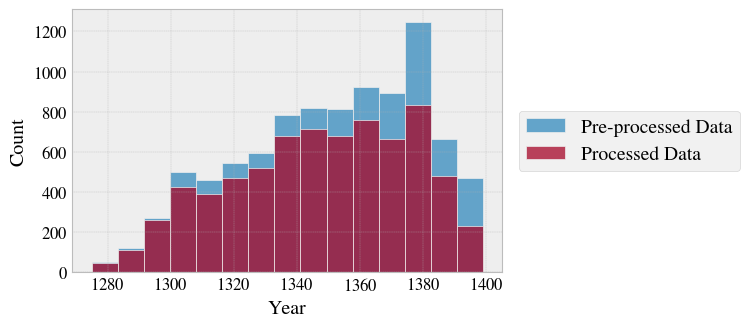

In [50]:
sources = ["pre-processed", "processed"]
labels = ["Pre-processed Data", "Processed Data"]

for i, source in enumerate(sources):
    data = df_pre_processed.year if source == "pre-processed" else df_processed.year
    sns.histplot(data[data >= 1275], bins=15, color=colors[i], label=labels[i])

#plt.legend(bbox_to_anchor=(0.5, -0.5), loc=8)
plt.legend(bbox_to_anchor=(1.575, 0.5), loc="center right")
plt.xlabel("Year")
plt.savefig("../data-push/0c-preprocessing-norm/processed-preprocessed.pdf", format="pdf", bbox_inches="tight")

plt.show()